<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

## Help Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.



---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [57]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split, StratifiedKFold

import patsy
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

* create a model predicts is this vegas or not ---->  vegas = 1, not_vegas = 0


In [58]:
business = pd.read_csv('/Users/amos/Desktop/DSI-SF-2/datasets/yelp_arizona_data/businesses_small_parsed.csv')
reviews = pd.read_csv('/Users/amos/Desktop/DSI-SF-2/datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv')
users = pd.read_csv('/Users/amos/Desktop/DSI-SF-2/datasets/yelp_arizona_data/users_small_parsed.csv')
checkins = pd.read_csv('/Users/amos/Desktop/DSI-SF-2/datasets/yelp_arizona_data/checkins_small_parsed.csv')
tips = pd.read_csv('/Users/amos/Desktop/DSI-SF-2/datasets/yelp_arizona_data/tips_small_nlp_parsed.csv')


In [59]:
business.head()
#predictor variables not needed = lattitude, longitude, neighborhoods

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",33.455885,-112.074177,[],attributes.Ambience.divey,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']",33.452154,-112.068620,[],attributes.Ambience.divey,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"['Fast Food', 'Mexican', 'Tex-Mex', 'Restauran...",33.465440,-112.069090,[],attributes.Ambience.divey,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"['Bars', 'Restaurants', 'American (Traditional...",33.448465,-112.071257,[],attributes.Ambience.divey,False


In [60]:
# Business_id is unique
print business.business_id.shape
print business.business_id.unique

(152832,)
<bound method Series.unique of 0         EmzaQR5hQlF0WIl24NxAZA
1         SiwN7f0N4bs4ZtPc4yPgiA
2         e5kc0CQ4R-PCCDgb274gSg
3         neGAQFkBNI8-rpPBLBzNkw
4         45puCRQ6Vh_IIAy7kkfFDQ
5         P7wKlbSRsoRrfH3DFOY08A
6         j8nyAaN_w5t6wYv-ni23sg
7         qsWxbgQwuomXvMseg23DGg
8         9BH18avE46LlHMvJn67MaA
9         tK91rSBc8SWa3XEQwe8D4A
10        gkv2XvXpFgiq4Bb2XK7YmQ
11        xH5axHFadmc7Veutt376TA
12        sInUSy63Oh455uWs9p9OqQ
13        QAe9UHKsxPdXQovBpaznMQ
14        muCl5p-9ut1sY0aKeUeRhw
15        oCA2OZcd_Jo_ggVmUx3WVw
16        JR95uaM82xBUIZ-kQ785iA
17        ldIxXmxD3Cku0vODGYb9dQ
18        c6sTwXAwIAgf2YQtA4ZWHg
19        ixTr1qXUFGTzyaZUuCDDvg
20        tb24fvNJfHhyKEXkKn12Xw
21        0VpsHbGLHDVKIKAi0ZliyQ
22        SZvYxcvYYVRue9MXcEDjsA
23        0De3TQ_uSOXwgduKL0va3w
24        JwjDSrMrKmHUXYqoIvTgUA
25        po5FyERB4lUZNnBIwnhFlg
26        I2IofjP2sHZUkv7pcoc33A
27        WyJuGTwFwoN0k8iX8FsqYw
28        W41CEzdKJe8wdDB-Rd6KJQ
29

In [61]:
def same(x):
    x = x.iloc[0]
    if len(x) == 0:
        return np.nan
    else:
        return x

bus_wide = pd.pivot_table(business, 
                               index=['business_id', 'name', 'review_count', 'city', 'stars', 'categories'], 
                               columns=['variable'],
                               values='value', aggfunc=same)

In [62]:
bus_wide = bus_wide.reset_index()

In [63]:
bus_wide['vegas_or_not'] = bus_wide['city'].map(lambda x: 1 if x == 'Las Vegas' else 0)
bus_wide.head()

variable,business_id,name,review_count,city,stars,categories,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,...,hours.Sunday.close,hours.Sunday.open,hours.Thursday.close,hours.Thursday.open,hours.Tuesday.close,hours.Tuesday.open,hours.Wednesday.close,hours.Wednesday.open,open,vegas_or_not
0,--jFTZmywe7StuZ2hEjxyA,Subway,7,Las Vegas,3.5,"['Fast Food', 'Sandwiches', 'Restaurants']",True,None,None,none,...,None,None,None,None,None,None,None,None,True,1
1,-0HGqwlfw3I8nkJyMHxAsQ,McDonald's,9,Phoenix,3.0,"['Burgers', 'Fast Food', 'Restaurants']",True,None,None,none,...,None,None,None,None,None,None,None,None,True,0
2,-0VK5Z1BfUHUYq4PoBYNLw,T Spot,5,Las Vegas,3.5,"['Bars', 'Nightlife', 'Lounges']",True,None,None,full_bar,...,None,None,None,None,None,None,None,None,True,1
3,-0bUDim5OGuv8R0Qqq6J4A,IHOP,8,Phoenix,2.0,"['Bakeries', 'Food', 'Breakfast & Brunch', 'Re...",True,None,None,None,...,None,None,None,None,None,None,None,None,False,0
4,-1bOb2izeJBZjHC7NWxiPA,First Watch,120,Phoenix,4.0,"['Breakfast & Brunch', 'Cafes', 'American (Tra...",True,None,None,none,...,14:30,06:30,14:30,06:30,14:30,06:30,14:30,06:30,True,0


In [64]:
list(bus_wide.columns)

['business_id',
 'name',
 'review_count',
 'city',
 'stars',
 'categories',
 'attributes.Accepts Credit Cards',
 'attributes.Accepts Insurance',
 'attributes.Ages Allowed',
 'attributes.Alcohol',
 'attributes.Ambience.casual',
 'attributes.Ambience.classy',
 'attributes.Ambience.divey',
 'attributes.Ambience.hipster',
 'attributes.Ambience.intimate',
 'attributes.Ambience.romantic',
 'attributes.Ambience.touristy',
 'attributes.Ambience.trendy',
 'attributes.Ambience.upscale',
 'attributes.Attire',
 'attributes.BYOB',
 'attributes.BYOB/Corkage',
 'attributes.By Appointment Only',
 'attributes.Caters',
 'attributes.Coat Check',
 'attributes.Corkage',
 'attributes.Delivery',
 'attributes.Dietary Restrictions.dairy-free',
 'attributes.Dietary Restrictions.gluten-free',
 'attributes.Dietary Restrictions.halal',
 'attributes.Dietary Restrictions.kosher',
 'attributes.Dietary Restrictions.soy-free',
 'attributes.Dietary Restrictions.vegan',
 'attributes.Dietary Restrictions.vegetarian',
 'at

In [65]:
bus_wide.rename(columns=lambda x: x.replace(' ','_').replace('.','_').replace('-','_').replace('/','_'), inplace=True)


In [66]:
print bus_wide.info()
list(bus_wide.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132 entries, 0 to 4131
Data columns (total 85 columns):
business_id                                    4132 non-null object
name                                           4132 non-null object
review_count                                   4132 non-null int64
city                                           4132 non-null object
stars                                          4132 non-null float64
categories                                     4132 non-null object
attributes_Accepts_Credit_Cards                3896 non-null object
attributes_Accepts_Insurance                   7 non-null object
attributes_Ages_Allowed                        101 non-null object
attributes_Alcohol                             3050 non-null object
attributes_Ambience_casual                     2873 non-null object
attributes_Ambience_classy                     2873 non-null object
attributes_Ambience_divey                      2864 non-null object
attributes_Am

['business_id',
 'name',
 'review_count',
 'city',
 'stars',
 'categories',
 'attributes_Accepts_Credit_Cards',
 'attributes_Accepts_Insurance',
 'attributes_Ages_Allowed',
 'attributes_Alcohol',
 'attributes_Ambience_casual',
 'attributes_Ambience_classy',
 'attributes_Ambience_divey',
 'attributes_Ambience_hipster',
 'attributes_Ambience_intimate',
 'attributes_Ambience_romantic',
 'attributes_Ambience_touristy',
 'attributes_Ambience_trendy',
 'attributes_Ambience_upscale',
 'attributes_Attire',
 'attributes_BYOB',
 'attributes_BYOB_Corkage',
 'attributes_By_Appointment_Only',
 'attributes_Caters',
 'attributes_Coat_Check',
 'attributes_Corkage',
 'attributes_Delivery',
 'attributes_Dietary_Restrictions_dairy_free',
 'attributes_Dietary_Restrictions_gluten_free',
 'attributes_Dietary_Restrictions_halal',
 'attributes_Dietary_Restrictions_kosher',
 'attributes_Dietary_Restrictions_soy_free',
 'attributes_Dietary_Restrictions_vegan',
 'attributes_Dietary_Restrictions_vegetarian',
 'at

In [67]:
# dropping columns with objects <= 7 non-null objects
drop_columns = ['attributes_Accepts_Insurance',
                'attributes_Dietary_Restrictions_dairy_free',
                'attributes_Dietary_Restrictions_gluten_free',
                'attributes_Dietary_Restrictions_halal',
                'attributes_Dietary_Restrictions_kosher',
                'attributes_Dietary_Restrictions_soy_free',
                'attributes_Dietary_Restrictions_vegan',
                'attributes_Dietary_Restrictions_vegetarian']

bus_wide.drop(drop_columns, axis=1, inplace=True)
bus_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132 entries, 0 to 4131
Data columns (total 77 columns):
business_id                          4132 non-null object
name                                 4132 non-null object
review_count                         4132 non-null int64
city                                 4132 non-null object
stars                                4132 non-null float64
categories                           4132 non-null object
attributes_Accepts_Credit_Cards      3896 non-null object
attributes_Ages_Allowed              101 non-null object
attributes_Alcohol                   3050 non-null object
attributes_Ambience_casual           2873 non-null object
attributes_Ambience_classy           2873 non-null object
attributes_Ambience_divey            2864 non-null object
attributes_Ambience_hipster          2871 non-null object
attributes_Ambience_intimate         2873 non-null object
attributes_Ambience_romantic         2873 non-null object
attributes_Ambience_tour

In [68]:

nonpredictors = ['business_id',
 'name',
 'review_count',
 'city',
 'stars',
 'categories',
'hours_Friday_close',
 'hours_Friday_open',
 'hours_Monday_close',
 'hours_Monday_open',
 'hours_Saturday_close',
 'hours_Saturday_open',
 'hours_Sunday_close',
 'hours_Sunday_open',
 'hours_Thursday_close',
 'hours_Thursday_open',
 'hours_Tuesday_close',
 'hours_Tuesday_open',
 'hours_Wednesday_close',
 'hours_Wednesday_open',
 'open',
 'vegas_or_not']

potential_variables = [x for x in bus_wide.columns if x not in nonpredictors]

In [69]:
for col in potential_variables:
    print col , '--------->', bus_wide[col].unique()

attributes_Accepts_Credit_Cards ---------> ['True' 'False' None]
attributes_Ages_Allowed ---------> [None '21plus' '18plus' 'allages']
attributes_Alcohol ---------> ['none' 'full_bar' None 'beer_and_wine']
attributes_Ambience_casual ---------> [None 'True' 'False']
attributes_Ambience_classy ---------> [None 'False' 'True']
attributes_Ambience_divey ---------> [None 'False' 'True']
attributes_Ambience_hipster ---------> [None 'False' 'True']
attributes_Ambience_intimate ---------> [None 'False' 'True']
attributes_Ambience_romantic ---------> [None 'False' 'True']
attributes_Ambience_touristy ---------> [None 'False' 'True']
attributes_Ambience_trendy ---------> [None 'False' 'True']
attributes_Ambience_upscale ---------> [None 'False' 'True']
attributes_Attire ---------> ['casual' None 'dressy' 'formal']
attributes_BYOB ---------> [None 'False' 'True']
attributes_BYOB_Corkage ---------> [None 'yes_free' 'yes_corkage' 'no']
attributes_By_Appointment_Only ---------> [None 'False' 'True']

In [70]:
# Assumption: None as False or boolean value 0
non_boolean_col = ['attributes_Ages_Allowed',
                   'attributes_Alcohol',
                   'attributes_Attire',
                   'attributes_BYOB_Corkage',
                   'attributes_Noise_Level',
                   'attributes_Price_Range',
                   'attributes_Smoking',
                   'attributes_Wi_Fi']

boolean_col = [col for col in potential_variables if col not in non_boolean_col]


In [71]:
# Setting up classification by assigning 'True' = 1, ('False' or None) = 0 
for col in boolean_col:
    bus_wide[col] = bus_wide[col].map(lambda x: 1 if x == 'True' else 0)
    
bus_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132 entries, 0 to 4131
Data columns (total 77 columns):
business_id                          4132 non-null object
name                                 4132 non-null object
review_count                         4132 non-null int64
city                                 4132 non-null object
stars                                4132 non-null float64
categories                           4132 non-null object
attributes_Accepts_Credit_Cards      4132 non-null int64
attributes_Ages_Allowed              101 non-null object
attributes_Alcohol                   3050 non-null object
attributes_Ambience_casual           4132 non-null int64
attributes_Ambience_classy           4132 non-null int64
attributes_Ambience_divey            4132 non-null int64
attributes_Ambience_hipster          4132 non-null int64
attributes_Ambience_intimate         4132 non-null int64
attributes_Ambience_romantic         4132 non-null int64
attributes_Ambience_touristy   

In [72]:
bus_wide.attributes_BYOB.unique()

array([0, 1])

In [73]:
for col in non_boolean_col:
    print bus_wide[col].unique(), col

[None '21plus' '18plus' 'allages'] attributes_Ages_Allowed
['none' 'full_bar' None 'beer_and_wine'] attributes_Alcohol
['casual' None 'dressy' 'formal'] attributes_Attire
[None 'yes_free' 'yes_corkage' 'no'] attributes_BYOB_Corkage
[None 'quiet' 'loud' 'average' 'very_loud'] attributes_Noise_Level
['1.0' '2.0' '3.0' '4.0' None] attributes_Price_Range
[None 'yes' 'no' 'outdoor'] attributes_Smoking
[None 'free' 'no' 'paid'] attributes_Wi_Fi


In [74]:
# After inspecting columns below I decided age class and attire are droppable
more_drop_columns = ['attributes_Ages_Allowed','attributes_Attire']
bus_wide.drop(more_drop_columns,axis=1, inplace=True)

In [75]:
bus_wide['attributes_Alcohol'] = bus_wide['attributes_Alcohol'].map(
                            lambda x: 1 if (x =='full_bar') or (x == 'beer_and_wine') else 0)

bus_wide['attributes_BYOB_Corkage'] = bus_wide['attributes_BYOB_Corkage'].map(
                            lambda x: 1 if (x =='yes_free') or (x == 'yes_corkage') else 0)

bus_wide['attributes_Noise_Level'] = bus_wide['attributes_Noise_Level'].map(
                            lambda x: 1 if (x =='loud') or (x == 'very_loud') else 0)

bus_wide['attributes_Smoking'] = bus_wide['attributes_Smoking'].map(
                            lambda x: 1 if (x =='yes') or (x == 'outdoor') else 0)

bus_wide['attributes_Wi_Fi'] = bus_wide['attributes_Wi_Fi'].map(
                            lambda x: 1 if (x =='free') or (x == 'paid') else 0)

In [76]:
# add 5 columns to my boolean_col list 
add_boolean_column = ['attributes_Alcohol','attributes_BYOB_Corkage',
                      'attributes_Noise_Level','attributes_Smoking','attributes_Wi_Fi']

for add in add_boolean_column:
    boolean_col.append(add)

In [77]:
#Convert below column into float
bus_wide['attributes_Price_Range'] = bus_wide['attributes_Price_Range'].map(
                            lambda x: np.nan if x == None else float(x))

In [78]:
bus_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132 entries, 0 to 4131
Data columns (total 75 columns):
business_id                          4132 non-null object
name                                 4132 non-null object
review_count                         4132 non-null int64
city                                 4132 non-null object
stars                                4132 non-null float64
categories                           4132 non-null object
attributes_Accepts_Credit_Cards      4132 non-null int64
attributes_Alcohol                   4132 non-null int64
attributes_Ambience_casual           4132 non-null int64
attributes_Ambience_classy           4132 non-null int64
attributes_Ambience_divey            4132 non-null int64
attributes_Ambience_hipster          4132 non-null int64
attributes_Ambience_intimate         4132 non-null int64
attributes_Ambience_romantic         4132 non-null int64
attributes_Ambience_touristy         4132 non-null int64
attributes_Ambience_trendy      

In [79]:
# wrapping a C() around categorical variables for the formula
cat_variables = []
for col in boolean_col:
    cat_variables.append('C(%s)' % col)

cat_variables

['C(attributes_Accepts_Credit_Cards)',
 'C(attributes_Ambience_casual)',
 'C(attributes_Ambience_classy)',
 'C(attributes_Ambience_divey)',
 'C(attributes_Ambience_hipster)',
 'C(attributes_Ambience_intimate)',
 'C(attributes_Ambience_romantic)',
 'C(attributes_Ambience_touristy)',
 'C(attributes_Ambience_trendy)',
 'C(attributes_Ambience_upscale)',
 'C(attributes_BYOB)',
 'C(attributes_By_Appointment_Only)',
 'C(attributes_Caters)',
 'C(attributes_Coat_Check)',
 'C(attributes_Corkage)',
 'C(attributes_Delivery)',
 'C(attributes_Dogs_Allowed)',
 'C(attributes_Drive_Thru)',
 'C(attributes_Good_For_Dancing)',
 'C(attributes_Good_For_Groups)',
 'C(attributes_Good_For_breakfast)',
 'C(attributes_Good_For_brunch)',
 'C(attributes_Good_For_dessert)',
 'C(attributes_Good_For_dinner)',
 'C(attributes_Good_For_latenight)',
 'C(attributes_Good_For_lunch)',
 'C(attributes_Good_for_Kids)',
 'C(attributes_Happy_Hour)',
 'C(attributes_Has_TV)',
 'C(attributes_Music_background_music)',
 'C(attributes

In [80]:
formula = 'vegas_or_not ~ ' + ' + '.join([col for col in cat_variables]) + ' - 1'
formula

'vegas_or_not ~ C(attributes_Accepts_Credit_Cards) + C(attributes_Ambience_casual) + C(attributes_Ambience_classy) + C(attributes_Ambience_divey) + C(attributes_Ambience_hipster) + C(attributes_Ambience_intimate) + C(attributes_Ambience_romantic) + C(attributes_Ambience_touristy) + C(attributes_Ambience_trendy) + C(attributes_Ambience_upscale) + C(attributes_BYOB) + C(attributes_By_Appointment_Only) + C(attributes_Caters) + C(attributes_Coat_Check) + C(attributes_Corkage) + C(attributes_Delivery) + C(attributes_Dogs_Allowed) + C(attributes_Drive_Thru) + C(attributes_Good_For_Dancing) + C(attributes_Good_For_Groups) + C(attributes_Good_For_breakfast) + C(attributes_Good_For_brunch) + C(attributes_Good_For_dessert) + C(attributes_Good_For_dinner) + C(attributes_Good_For_latenight) + C(attributes_Good_For_lunch) + C(attributes_Good_for_Kids) + C(attributes_Happy_Hour) + C(attributes_Has_TV) + C(attributes_Music_background_music) + C(attributes_Music_dj) + C(attributes_Music_jukebox) + C(a

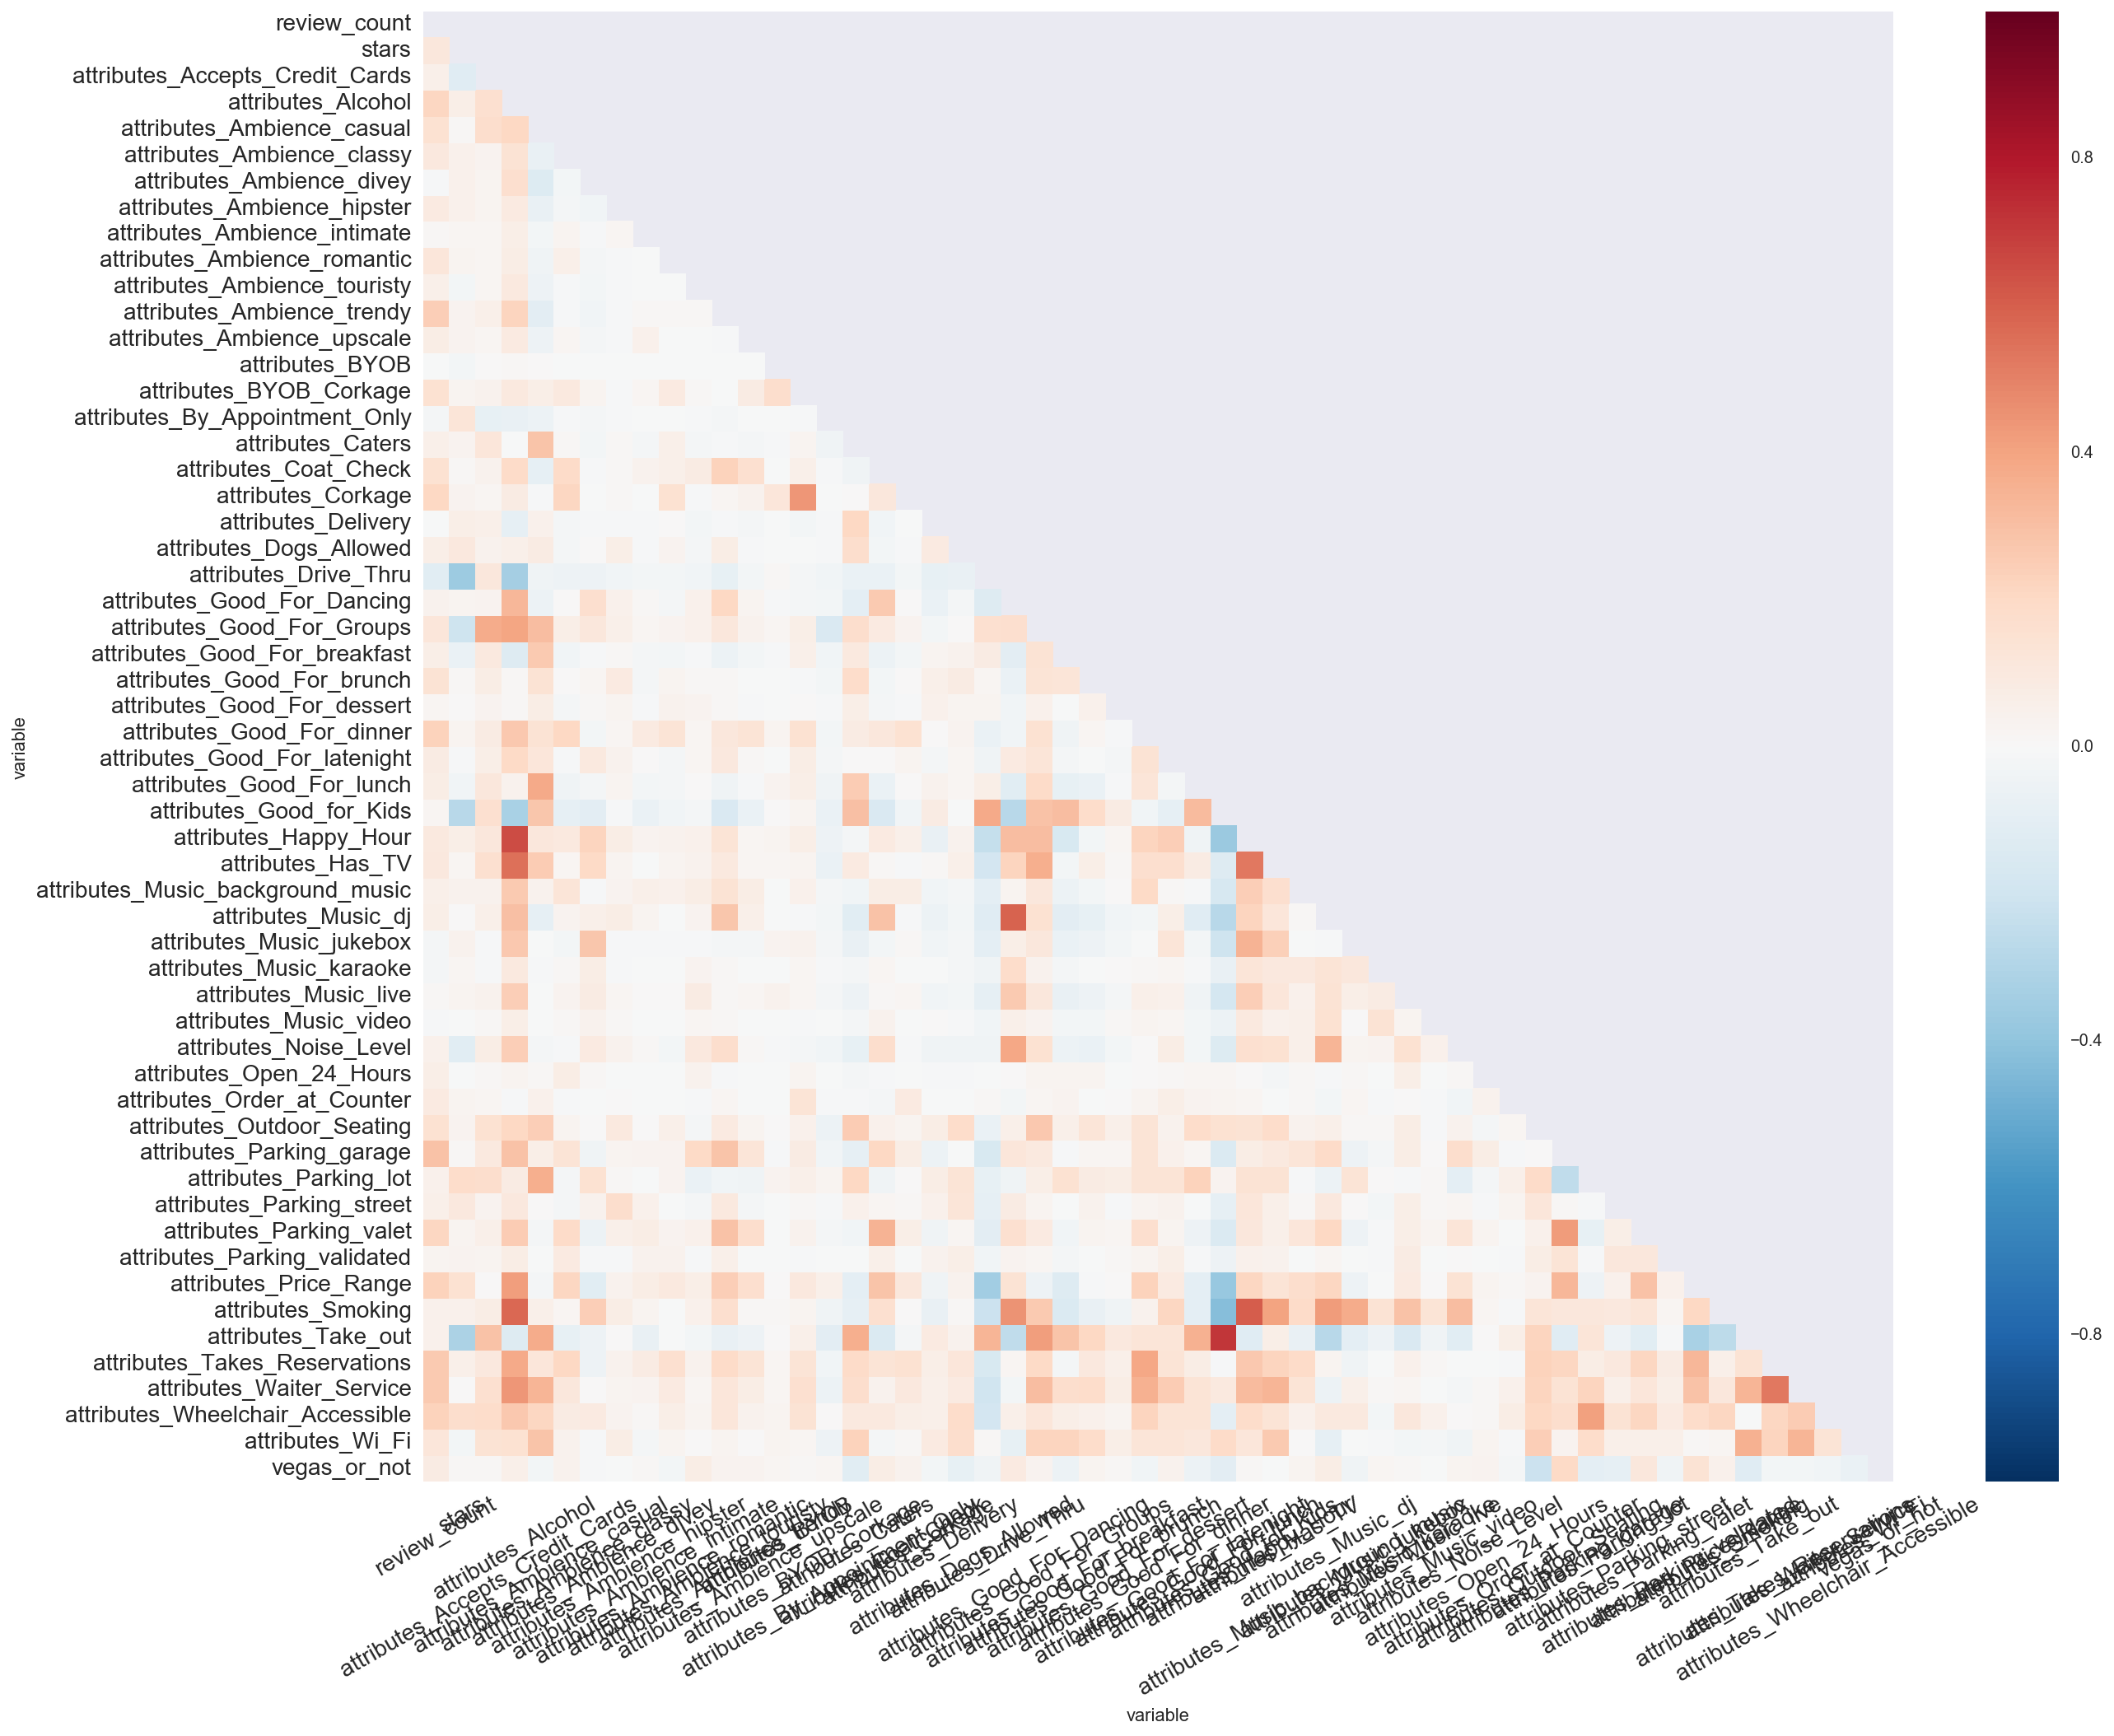

In [81]:
corrs = bus_wide.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(20,16))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [82]:
y, X = patsy.dmatrices(formula, data=bus_wide, return_type='dataframe')

In [83]:
y = np.ravel(y)

In [84]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.4)

In [85]:
lr_params = {
    'solver':['liblinear'],
    'penalty':['l2','l1'],
    'C':np.linspace(0.0001,1000.,50)
}

In [86]:
# Gridsearch best parameters for your model
vegas_gs = GridSearchCV(LogisticRegression(), lr_params, cv=10, verbose=1)

vegas_gs.fit(X_tr, y_tr)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   15.7s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.1s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': array([  1.00000e-04,   2.04083e+01,   4.08164e+01,   6.12246e+01,
         8.16327e+01,   1.02041e+02,   1.22449e+02,   1.42857e+02,
         1.63265e+02,   1.83674e+02,   2.04082e+02,   2.24490e+02,
         2.44898e+02,   2.65306e+02,   2.85714e+02,   3.0...7e+02,   9.38776e+02,   9.59184e+02,
         9.79592e+02,   1.00000e+03]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [87]:
vegas_lr = vegas_gs.best_estimator_
print vegas_gs.best_params_
print vegas_gs.best_score_, np.abs(0.5 - np.mean(y_tr)) + 0.5
# definitely outperforms the baseline but not by much

{'penalty': 'l1', 'C': 306.12251836734691, 'solver': 'liblinear'}
0.670431625656 0.622025010085


In [88]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

def plot_roc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    fpr_, tpr_, _ = roc_curve(y, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y)) + 0.5
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('false positive rate', fontsize=16)
    axr.set_ylabel('true positive rate', fontsize=16)
    axr.set_title(varname+' vs. not ROC curve\n', fontsize=20)

    axr.legend(loc="lower right", fontsize=12)

    plt.show()

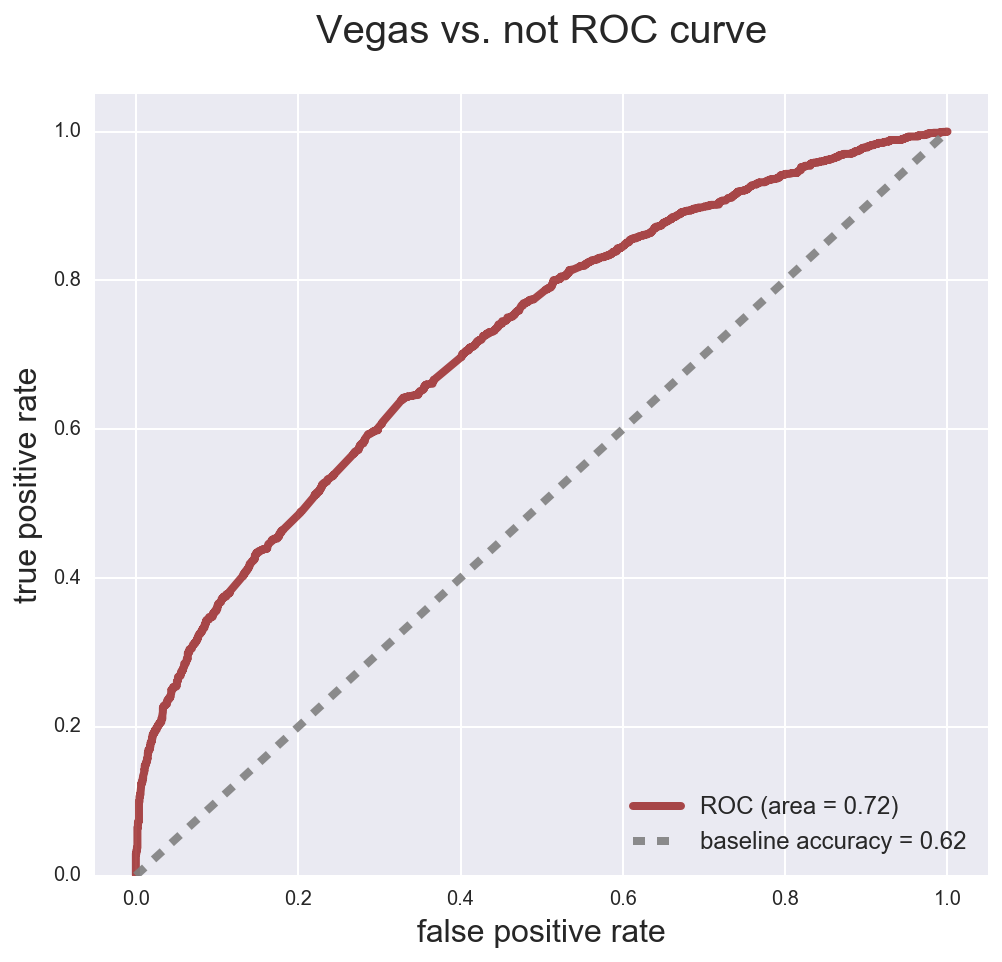

In [89]:
plot_roc(vegas_lr, X, y, 'Vegas')

In [90]:
from sklearn.metrics import confusion_matrix

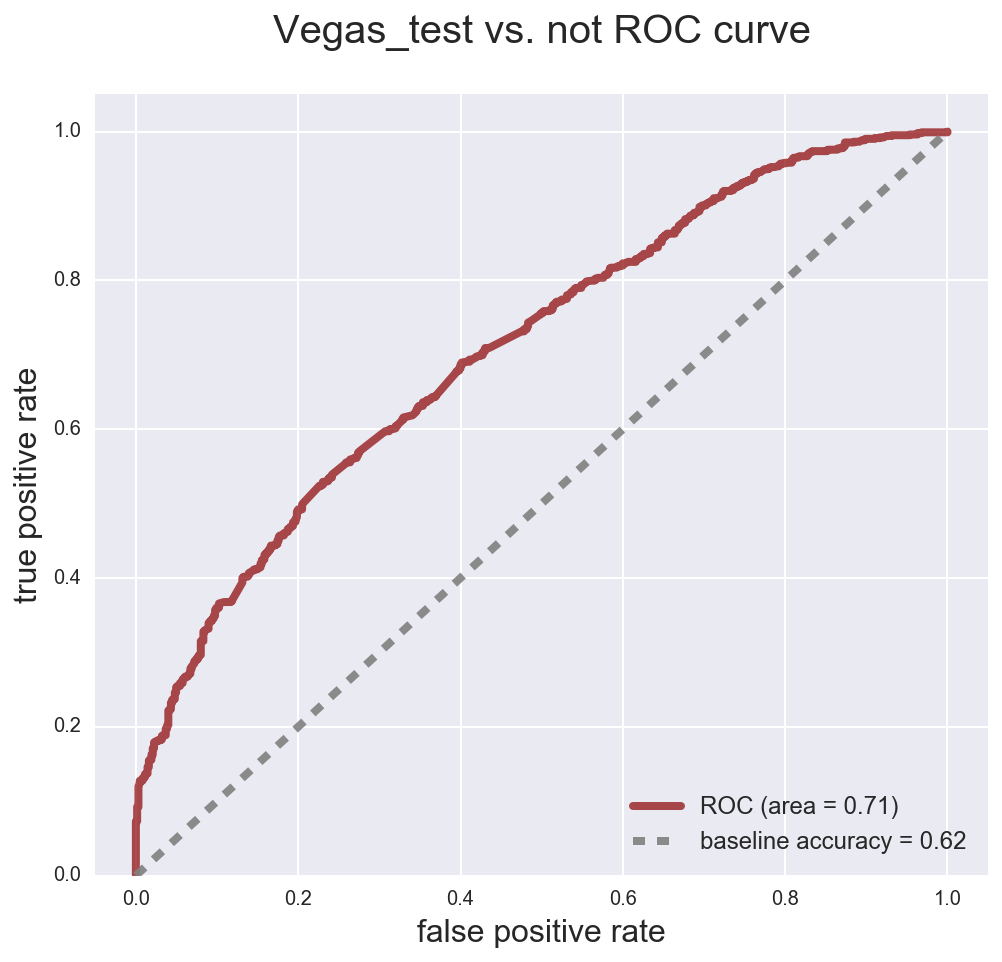

Vegas confusion matrix(test data):


,0,1
0,231,394
1,169,859


In [91]:
plot_roc(vegas_lr, X_te, y_te, 'Vegas_test')

print 'Vegas confusion matrix(test data):'
pd.DataFrame(confusion_matrix(y_te, vegas_lr.predict(X_te)))

In [92]:
model = vegas_lr.fit(X_te, y_te)

In [93]:
print "The accuracy of my model: ", model.score(X_te, y_te)

The accuracy of my model:  0.659407138536


In [94]:
# Method to plot precision/recall curve
from sklearn.metrics import (precision_recall_curve, average_precision_score, f1_score)

def plot_prauc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_pp)
    avg_precision = average_precision_score(y, y_pp)
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(recall, precision, label='PRAUC (area = %0.2f)' % avg_precision,
             color='steelblue', linewidth=4,
             alpha=0.7)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('recall', fontsize=16)
    axr.set_ylabel('precision', fontsize=16)
    axr.set_title(varname+' vs. not PRAUC curve\n', fontsize=20)

    axr.legend(loc="upper right", fontsize=12)

    plt.show()

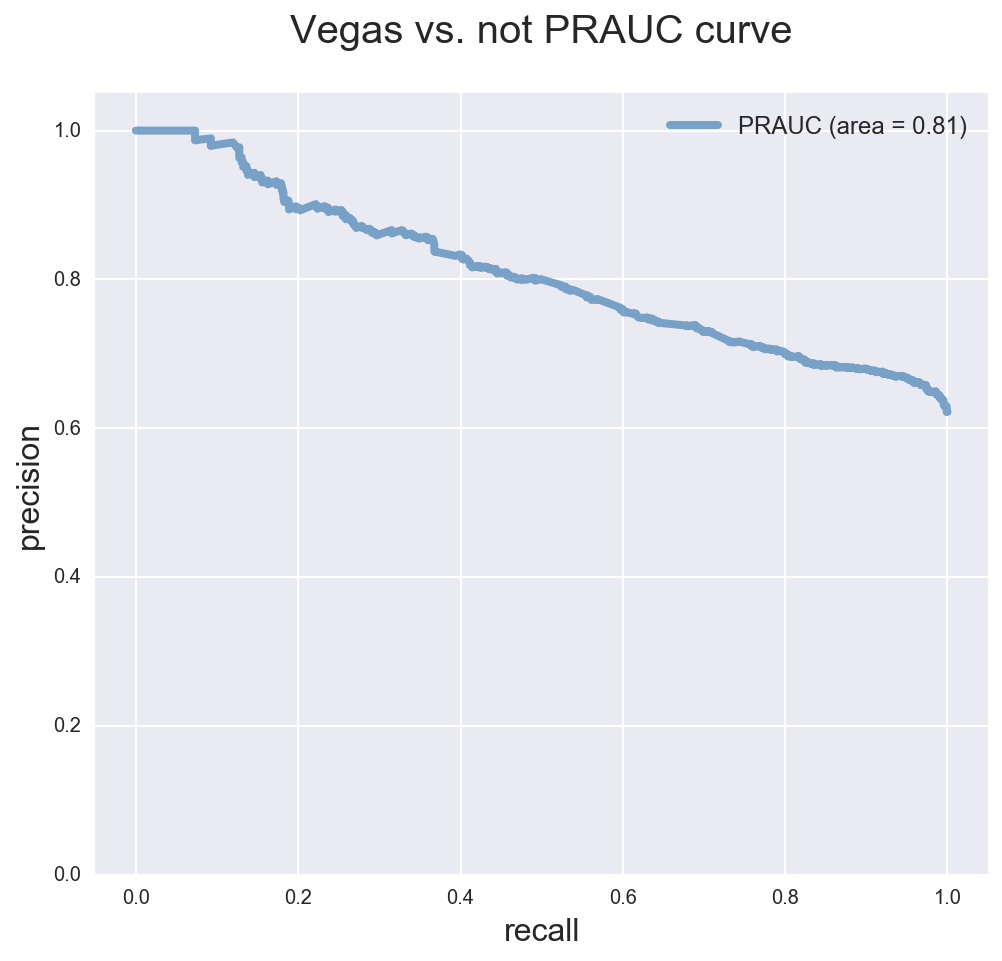

In [95]:
plot_prauc(vegas_lr, X_te, y_te, 'Vegas')

In [96]:
# Gridsearches with keyword argument scoring='f1'

vegas_f1_gs = GridSearchCV(LogisticRegression(), lr_params, 
                           cv=10, verbose=1, scoring='f1')

vegas_f1_gs.fit(X_tr, y_tr)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    8.8s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   15.2s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   18.4s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': array([  1.00000e-04,   2.04083e+01,   4.08164e+01,   6.12246e+01,
         8.16327e+01,   1.02041e+02,   1.22449e+02,   1.42857e+02,
         1.63265e+02,   1.83674e+02,   2.04082e+02,   2.24490e+02,
         2.44898e+02,   2.65306e+02,   2.85714e+02,   3.0...7e+02,   9.38776e+02,   9.59184e+02,
         9.79592e+02,   1.00000e+03]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=1)

In [97]:
vegas_f1_lr = vegas_f1_gs.best_estimator_
print vegas_f1_gs.best_params_
print vegas_f1_gs.best_score_

{'penalty': 'l2', 'C': 0.0001, 'solver': 'liblinear'}
0.766972810119


In [98]:
# Confusion matrix on new model with f1 score instead of accuracy as measure
print 'Vegas confusion matrix on test data:'
pd.DataFrame(confusion_matrix(y_te, vegas_f1_lr.predict(X_te)))


Vegas confusion matrix on test data:


,0,1
0,0,625
1,0,1028


In [99]:
from sklearn.metrics import f1_score
print "The f1 score of this model: ", f1_score(y_te, vegas_f1_lr.predict(X_te))

The f1 score of this model:  0.766878030586


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [100]:
reviews.rename(columns=(lambda x: x.replace(' ', '_').replace('.','')), inplace=True)
list(reviews.columns)

['user_id',
 'review_id',
 'votescool',
 'business_id',
 'votesfunny',
 'stars',
 'date',
 'votesuseful',
 '10_minutes',
 '15_minutes',
 '20_minutes',
 '30_minutes',
 'bar_food',
 'beer_selection',
 'best_ve',
 'bloody_mary',
 'bottle_service',
 'chicken_waffles',
 'customer_service',
 'dance_floor',
 'decided_try',
 'definitely_come',
 'definitely_recommend',
 'didn_want',
 'don_know',
 'don_like',
 'don_think',
 'don_want',
 'eggs_benedict',
 'fast_food',
 'feel_like',
 'felt_like',
 'fish_chips',
 'food_amazing',
 'food_came',
 'food_delicious',
 'food_good',
 'food_great',
 'food_just',
 'food_service',
 'french_fries',
 'french_toast',
 'friday_night',
 'fried_chicken',
 'friendly_staff',
 'good_food',
 'good_place',
 'good_service',
 'good_thing',
 'good_time',
 'great_atmosphere',
 'great_experience',
 'great_food',
 'great_place',
 'great_service',
 'great_time',
 'happy_hour',
 'hash_browns',
 'highly_recommend',
 'hip_hop',
 'ice_cream',
 'just_like',
 'just_ok',
 'just_right

In [219]:
# excluded dance_floor and happy_hour
service=['friendly_staff',
 'food_service',
 'good_service',
 'great_experience',
 'service_excellent',
 'service_food',
 'service_friendly',
 'service_good',
 'service_great',
 'staff_friendly',
 'super_friendly',
 'wait_staff',
 '10_minutes',
 '15_minutes',
 '20_minutes',
 '30_minutes',
 'fast_food',
 'feel_like',
 'felt_like',
 'food_came']
print type(service)

<type 'list'>


In [220]:
food = ['food_amazing',
 'food_delicious',
 'food_good',
 'food_great',
 'food_just',
 'great_experience',
 'good_food',
 'great_food',
 'quality_food',
 'bar_food',
 'beer_selection',
 'best_ve',
 'bloody_mary',
 'chicken_waffles',
 'decided_try',
 'definitely_come',
 'definitely_recommend',
 'eggs_benedict',
 'french_fries',
 'french_toast']

print food

['food_amazing', 'food_delicious', 'food_good', 'food_great', 'food_just', 'great_experience', 'good_food', 'great_food', 'quality_food', 'bar_food', 'beer_selection', 'best_ve', 'bloody_mary', 'chicken_waffles', 'decided_try', 'definitely_come', 'definitely_recommend', 'eggs_benedict', 'french_fries', 'french_toast']


In [221]:


more_food = ['sweet_potato','tasted_like','red_velvet','really_good','pretty_good','potato_fries','red_velvet','onion_rings',
            'medium_rare','mashed_potatoes','mac_cheese', 'hash_browns','fried_chicken','fish_chips', 'ice_cream']

more_service = ['saturday_night','right_away','really_nice','really_enjoyed','minutes_later','hip_hop','great_time',
               'great_service','great_atmosphere','friday_night','customer_service','bottle_service']

#need to append more variables into food and service lists

for more_f in more_food: 
    food.append(more_f)
for more_ser in more_service:
    service.append(more_ser)
    
print food
print "---------------"
print service

['food_amazing', 'food_delicious', 'food_good', 'food_great', 'food_just', 'great_experience', 'good_food', 'great_food', 'quality_food', 'bar_food', 'beer_selection', 'best_ve', 'bloody_mary', 'chicken_waffles', 'decided_try', 'definitely_come', 'definitely_recommend', 'eggs_benedict', 'french_fries', 'french_toast', 'sweet_potato', 'tasted_like', 'red_velvet', 'really_good', 'pretty_good', 'potato_fries', 'red_velvet', 'onion_rings', 'medium_rare', 'mashed_potatoes', 'mac_cheese', 'hash_browns', 'fried_chicken', 'fish_chips', 'ice_cream']
---------------
['friendly_staff', 'food_service', 'good_service', 'great_experience', 'service_excellent', 'service_food', 'service_friendly', 'service_good', 'service_great', 'staff_friendly', 'super_friendly', 'wait_staff', '10_minutes', '15_minutes', '20_minutes', '30_minutes', 'fast_food', 'feel_like', 'felt_like', 'food_came', 'saturday_night', 'right_away', 'really_nice', 'really_enjoyed', 'minutes_later', 'hip_hop', 'great_time', 'great_serv

In [222]:
#Checking null values within each column and total mean value of each column in lists service and food.
mean_total_service = 0
for ser in service:
    print ser, "unique values-->" , reviews[ser].unique(), "|", "null values:",reviews[ser].isnull().sum()
    mean_total_service += np.mean(reviews[ser].values)
    
print "----------------------"

mean_total_food = 0
for fo in food:
    print fo, "unique values-->" , reviews[fo].unique(), "|", "null values:",reviews[fo].isnull().sum()
    mean_total_food += np.mean(reviews[fo].values)
    

print "total service:", mean_total_service
print "total food:", mean_total_food

friendly_staff unique values--> [0 1 2] | null values: 0
food_service unique values--> [0 1 2 3 4] | null values: 0
good_service unique values--> [0 1 3 2] | null values: 0
great_experience unique values--> [0 1 2] | null values: 0
service_excellent unique values--> [0 1 2] | null values: 0
service_food unique values--> [0 1 2 3] | null values: 0
service_friendly unique values--> [0 1 2] | null values: 0
service_good unique values--> [0 1 2] | null values: 0
service_great unique values--> [0 1 2] | null values: 0
staff_friendly unique values--> [0 1 2] | null values: 0
super_friendly unique values--> [0 1 2 3] | null values: 0
wait_staff unique values--> [0 1 2 3 4] | null values: 0
10_minutes unique values--> [0 1 2 3 4 5 6] | null values: 0
15_minutes unique values--> [0 1 2 3 4 5 7] | null values: 0
20_minutes unique values--> [0 1 2 3 4] | null values: 0
30_minutes unique values--> [0 1 2 3 4] | null values: 0
fast_food unique values--> [0 1 2 3 4 6 5 8 9] | null values: 0
feel_lik

In [223]:
# final version of food and service list. 
# I will use these lists to divide reviews that are service centered vs food centered.
print food
print '--------------------'
print service

['food_amazing', 'food_delicious', 'food_good', 'food_great', 'food_just', 'great_experience', 'good_food', 'great_food', 'quality_food', 'bar_food', 'beer_selection', 'best_ve', 'bloody_mary', 'chicken_waffles', 'decided_try', 'definitely_come', 'definitely_recommend', 'eggs_benedict', 'french_fries', 'french_toast', 'sweet_potato', 'tasted_like', 'red_velvet', 'really_good', 'pretty_good', 'potato_fries', 'red_velvet', 'onion_rings', 'medium_rare', 'mashed_potatoes', 'mac_cheese', 'hash_browns', 'fried_chicken', 'fish_chips', 'ice_cream']
--------------------
['friendly_staff', 'food_service', 'good_service', 'great_experience', 'service_excellent', 'service_food', 'service_friendly', 'service_good', 'service_great', 'staff_friendly', 'super_friendly', 'wait_staff', '10_minutes', '15_minutes', '20_minutes', '30_minutes', 'fast_food', 'feel_like', 'felt_like', 'food_came', 'saturday_night', 'right_away', 'really_nice', 'really_enjoyed', 'minutes_later', 'hip_hop', 'great_time', 'great

In [51]:
# def cvscore(fclist):
#     sd = np.std(fclist)
#     mean = np.mean(fclist)
#     cv = sd/mean
#     return cv

# df = pd.DataFrame({'AAA' : ['w','x','y','z'], 'BBB' : [10,20,30,40],
#                    'CCC' : [100,50,-30,-50]})

# df['Score'] = df.iloc[:, 1:].apply(cvscore, axis=1)

# def sublst(row):
#     return lst[row['J1']:row['J2']]

# df = pd.DataFrame({'ID':['1','2','3'], 'J1': [0,2,3], 'J2':[1,4,5]})
# print df
# lst = ['a','b','c','d','e','f']

# df['J3'] = df.apply(sublst,axis=1)
# print df

In [191]:
# Create a column 'mean_total_service' of average score based on service reviews across columns in the list service.
reviews['sum_total_service'] = reviews[service].sum(axis=1)
reviews.head()



,user_id,review_id,votescool,business_id,votesfunny,stars,date,votesuseful,10_minutes,15_minutes,...,sweet_potato,tasted_like,time_vegas,try_place,ve_seen,ve_tried,wait_staff,mean_total_food,mean_total_service,sum_total_service
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0.0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0.0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,0.0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,0.0,1,1


In [177]:
reviews.mean_total_food.unique()

array([ 0.        ,  0.02857143,  0.11428571,  0.08571429,  0.05714286,
        0.25714286,  0.2       ,  0.14285714,  0.17142857,  0.22857143,
        0.37142857,  0.34285714,  0.31428571,  0.28571429,  0.4       ,
        0.51428571,  0.6       ])

In [192]:
# Create a column 'mean_total_food' of average score based on food reviews across columns in the list food.
reviews['sum_total_food'] = reviews[food].sum(axis=1)
reviews.head()

,user_id,review_id,votescool,business_id,votesfunny,stars,date,votesuseful,10_minutes,15_minutes,...,tasted_like,time_vegas,try_place,ve_seen,ve_tried,wait_staff,mean_total_food,mean_total_service,sum_total_service,sum_total_food
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0.0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0.0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0.0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0.0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0.0,1,1,0


In [193]:


# print reviews[(reviews['sum_total_food'] <= reviews['sum_total_service']) & (reviews['sum_total_service'] != 0.0)].shape
# print reviews[(reviews['sum_total_food'] <= reviews['sum_total_service'])].shape
# print reviews[(reviews['sum_total_food'] >= reviews['sum_total_service']) & (reviews['sum_total_food'] != 0.0)].shape

# reviews.drop('mean_total_food',axis=1, inplace=True)
# reviews.head()

# Subsetting reviews where mean_total_food is not 0 and is greater than mean_total_service
# mask = (reviews['sum_total_service'] > reviews['sum_total_food'])# & (reviews['sum_total_service'] != 0.0)
# sub_reviews = reviews.loc[mask, :].reset_index()

#print sub_review.shape
# print type(sub_reviews), sub_reviews.shape

(91201, 112)
(248722, 112)
(94472, 112)


In [206]:
# sub_reviews['service_over_food'] = sub_reviews['sum_total_service'] - sub_reviews['sum_total_food']


,index,user_id,review_id,votescool,business_id,votesfunny,stars,date,votesuseful,10_minutes,...,sweet_potato,tasted_like,time_vegas,try_place,ve_seen,ve_tried,wait_staff,sum_total_service,sum_total_food,service_over_food
0,4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,...,0,0,0,0,0,0,0,1,0,1
1,7,PnsKyueIKIIimnRGo0niWw,oOYyD6oLLKPm-lj9H9whSw,0,EmzaQR5hQlF0WIl24NxAZA,1,2,2012-10-02,1,0,...,0,0,0,0,0,0,0,1,0,1
2,11,Rcg_gNUb4O8yV5Ww6vUqsg,JOUBXSYMEFNiE6n2tWbEbQ,1,EmzaQR5hQlF0WIl24NxAZA,5,3,2013-07-06,1,0,...,0,0,0,0,0,0,0,1,0,1
3,12,qwAP7Ut4C3owLSX_LzRlgQ,R75neRMrLZJo7fIgC2TRnA,0,EmzaQR5hQlF0WIl24NxAZA,0,2,2013-10-06,2,0,...,0,0,0,0,0,0,0,1,0,1
4,14,x2aI5KOLVAW1CEEyoofJfQ,wOjC7DQHSqShOyER_8-qjg,1,EmzaQR5hQlF0WIl24NxAZA,1,3,2014-02-08,1,0,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
# failed attempt to apply 

#def service_vs_food(row):
# food_var_sum = 0
# service_var_sum = 0

# for i in range(50):
#     print reviews.loc[i,:]
#     for f in food:
#         food_var_sum += reviews.loc[i,:][f]

# food_var_sum       
#reviews['service_or_food'] = reviews.iloc[:,1:].apply(service_vs_food, axis=1)

In [228]:
reviews.stars.isnull().sum()

0

In [229]:
target = "stars"

y = reviews[target].values
X_food = pd.DataFrame(data=reviews, columns=food)
X_service = pd.DataFrame(data=reviews, columns=service)

print y.shape
print X_food.shape
print X_service.shape

(322398,)
(322398, 35)
(322398, 32)


In [233]:
from sklearn.preprocessing import StandardScaler

ss1 = StandardScaler()
ss2 = StandardScaler()
Xn_food = ss1.fit_transform(X_food)
Xn_service = ss2.fit_transform(X_service)

print Xn_food.shape
print Xn_service.shape

(322398, 35)
(322398, 32)


# Hypothesis: X_food will create a better score than X_service on target column stars. I will create a linear Regression model.

In [234]:
linreg = LinearRegression()
model = cross_val_score(linreg, Xn_food, y, cv=10, verbose=1)

print "Scores based on food predictor variables: ", model
print "Average score: ", np.mean(model)

Scores based on food predictor variables:  [ 0.02697973  0.02652711  0.03873131  0.01676752  0.02717063  0.03171686
  0.03461325  0.03970222  0.04013378  0.03559663]
Average score:  0.0317939055215


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished


In [236]:
lr = LinearRegression()
model_service = cross_val_score(lr, Xn_service, y, cv=10, verbose=1)

print "Scores based on service predictor variables: ", model_service
print "Average score: ", np.mean(model_service)

Scores based on service predictor variables:  [ 0.05069805  0.03362114  0.03954969  0.03869466  0.04457684  0.05219212
  0.06030137  0.06176144  0.06104292  0.05348177]
Average score:  0.0495920018282


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished


### Conclusion: Both are very bad predictors of stars but with a slight winning edge on service predictors.

note:
I did not have a chance to merge tips to add more predictor variables in the mix but the data cleanning and choosing which predictor variables took a big chunk of time. 

A total fail note: I attempted to create a target binary column based on service and food comparing the average total of 'food' scores and 'service' scores but I ended up with a column of only 1 or only 0 values.  



<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [217]:
list(users.elite.unique())

['[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]',
 '[2005]',
 '[]',
 '[2005, 2006, 2007, 2008, 2010, 2011, 2012]',
 '[2012, 2013, 2014, 2015]',
 '[2013]',
 '[2013, 2014, 2015]',
 '[2014, 2015]',
 '[2008, 2009, 2010, 2011]',
 '[2011, 2012, 2013, 2014, 2015]',
 '[2010, 2011, 2012, 2013]',
 '[2006, 2007, 2008]',
 '[2009, 2010]',
 '[2012, 2013, 2014]',
 '[2015]',
 '[2009, 2010, 2011, 2012, 2013, 2014, 2015]',
 '[2009, 2010, 2011, 2012]',
 '[2011, 2012]',
 '[2010, 2011]',
 '[2007]',
 '[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]',
 '[2006, 2007, 2008, 2009]',
 '[2010]',
 '[2010, 2011, 2012, 2013, 2014, 2015]',
 '[2013, 2014]',
 '[2010, 2011, 2012]',
 '[2011, 2012, 2013]',
 '[2006, 2007, 2009, 2010]',
 '[2006]',
 '[2011]',
 '[2005, 2006]',
 '[2012, 2013]',
 '[2014]',
 '[2005, 2006, 2007]',
 '[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]',
 '[2009, 2010, 2011]',
 '[2010, 2012]',
 '[2011, 2012, 2013, 2014]',
 '[2006, 2007, 2008, 2009, 2010]',
 '[2008, 2009]',
 '[200

In [240]:
users.head()

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


In [244]:
users.rename(columns=(lambda x: x.replace('.','_')), inplace=True)
users.columns

Index([u'yelping_since', u'compliments_plain', u'review_count',
       u'compliments_cute', u'compliments_writer', u'fans',
       u'compliments_note', u'compliments_hot', u'compliments_cool',
       u'compliments_profile', u'average_stars', u'compliments_more', u'elite',
       u'name', u'user_id', u'votes_cool', u'compliments_list', u'votes_funny',
       u'compliments_photos', u'compliments_funny', u'votes_useful'],
      dtype='object')

In [245]:
print list(users.columns)
print users.shape

['yelping_since', 'compliments_plain', 'review_count', 'compliments_cute', 'compliments_writer', 'fans', 'compliments_note', 'compliments_hot', 'compliments_cool', 'compliments_profile', 'average_stars', 'compliments_more', 'elite', 'name', 'user_id', 'votes_cool', 'compliments_list', 'votes_funny', 'compliments_photos', 'compliments_funny', 'votes_useful']
(144206, 21)


In [282]:
old = pd.read_csv('/Users/amos/Desktop/DSI-SF-2/datasets/yelp_arizona_data/users_small_parsed.csv')

In [287]:
old.head()

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


In [290]:
def to_list(x):
    new = []
    if ',' in x:
        new = x.replace("'", '').replace('[','').replace(']', '').replace(' ','').split(',')
    elif ',' not in x:
        if '20' in x:
            new = [x.replace("'",'').replace('[','').replace(']', '')]
    return new

users.elite = old.elite.map(to_list)
users.head(10)

,yelping_since,compliments_plain,review_count,compliments_cute,compliments_writer,fans,compliments_note,compliments_hot,compliments_cool,compliments_profile,...,compliments_more,elite,name,user_id,votes_cool,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404
5,2008-11,6.0,362,1.0,5.0,7,4.0,4.0,10.0,NaN,...,NaN,"[2012, 2013, 2014, 2015]",Steven,za5Q2uYrTmky9w_3h9k_wQ,77,NaN,60,NaN,1.0,255
6,2008-11,1.0,24,NaN,NaN,1,1.0,1.0,2.0,NaN,...,1.0,[],King,AzoZZ1hRToPsnUPXeRXelg,12,NaN,8,NaN,NaN,44
7,2009-08,NaN,23,NaN,NaN,0,NaN,NaN,NaN,NaN,...,NaN,[],Angela,bWNn5RzthU9-yo5VYQB20g,2,NaN,2,NaN,NaN,14
8,2010-07,NaN,13,NaN,NaN,1,NaN,NaN,1.0,NaN,...,NaN,[],Heather,E_DJ1nTDPt9Qk2abWFTefQ,7,NaN,1,NaN,NaN,13
9,2011-09,NaN,14,NaN,NaN,0,NaN,NaN,NaN,NaN,...,1.0,[],Angela,gh2_LticbfRCOlfRXx3fPQ,4,NaN,6,NaN,NaN,24


In [294]:
len(users.elite[0])

11

In [281]:
x = '[2015]'
print len(x.replace("'",'').replace('[','').replace(']', '').split(','))


1


In [295]:
users.elite = users.elite.map(lambda x: len(x))
users.head()

,yelping_since,compliments_plain,review_count,compliments_cute,compliments_writer,fans,compliments_note,compliments_hot,compliments_cool,compliments_profile,...,compliments_more,elite,name,user_id,votes_cool,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,11,Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,11,Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,1,Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,0,Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,7,Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


In [271]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 21 columns):
yelping_since          144206 non-null object
compliments_plain      47034 non-null float64
review_count           144206 non-null int64
compliments_cute       13133 non-null float64
compliments_writer     33222 non-null float64
fans                   144206 non-null int64
compliments_note       39872 non-null float64
compliments_hot        31748 non-null float64
compliments_cool       41069 non-null float64
compliments_profile    12368 non-null float64
average_stars          144206 non-null float64
compliments_more       25066 non-null float64
elite                  144206 non-null int64
name                   144206 non-null object
user_id                144206 non-null object
votes_cool             144206 non-null int64
compliments_list       7180 non-null float64
votes_funny            144206 non-null int64
compliments_photos     18759 non-null float64
compliments_funny   

In [304]:

X = pd.DataFrame(data=users, columns=[col for col in users.columns[1:]])
X.drop(['name','user_id'], axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 18 columns):
compliments_plain      47034 non-null float64
review_count           144206 non-null int64
compliments_cute       13133 non-null float64
compliments_writer     33222 non-null float64
fans                   144206 non-null int64
compliments_note       39872 non-null float64
compliments_hot        31748 non-null float64
compliments_cool       41069 non-null float64
compliments_profile    12368 non-null float64
average_stars          144206 non-null float64
compliments_more       25066 non-null float64
elite                  144206 non-null int64
votes_cool             144206 non-null int64
compliments_list       7180 non-null float64
votes_funny            144206 non-null int64
compliments_photos     18759 non-null float64
compliments_funny      30612 non-null float64
votes_useful           144206 non-null int64
dtypes: float64(12), int64(6)
memory usage: 19.8 MB


In [306]:
X.drop(['compliments_list','compliments_profile','compliments_cute','compliments_photos'], axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 14 columns):
compliments_plain     47034 non-null float64
review_count          144206 non-null int64
compliments_writer    33222 non-null float64
fans                  144206 non-null int64
compliments_note      39872 non-null float64
compliments_hot       31748 non-null float64
compliments_cool      41069 non-null float64
average_stars         144206 non-null float64
compliments_more      25066 non-null float64
elite                 144206 non-null int64
votes_cool            144206 non-null int64
votes_funny           144206 non-null int64
compliments_funny     30612 non-null float64
votes_useful          144206 non-null int64
dtypes: float64(8), int64(6)
memory usage: 15.4 MB


In [307]:
X.drop(['compliments_plain','compliments_writer','compliments_note','compliments_hot', 'compliments_cool',
       'compliments_more', 'compliments_funny'], axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 7 columns):
review_count     144206 non-null int64
fans             144206 non-null int64
average_stars    144206 non-null float64
elite            144206 non-null int64
votes_cool       144206 non-null int64
votes_funny      144206 non-null int64
votes_useful     144206 non-null int64
dtypes: float64(1), int64(6)
memory usage: 7.7 MB


In [297]:
# Target variable assuming elite if was elite anytime as a 'yelper' 
y = users.elite.map(lambda x: 1 if x > 0 else 0)
print y.shape

(144206,)


In [298]:
y.unique()

array([1, 0])

In [308]:
ss3 = StandardScaler()
Xn_user = ss3.fit_transform(X)

In [313]:
scores = cross_val_score(LogisticRegression(), Xn_user, y, cv=10,verbose=1)

print scores
print "mean scores: ", np.mean(scores) 

[ 0.99993066  1.          0.99993066  1.          1.          1.          1.
  1.          1.          1.        ]
mean scores:  0.999986132298


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished


# Conclusion: X contains a variable that directly correlates with y. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?